<a href="https://colab.research.google.com/github/shuaigezhu/starDist/blob/master/Three_mag_lambda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import**

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from random import randint
import glob

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11567875745612217389
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11817667789
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 17923722126474240693
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:82:00.0, compute capability: 6.0"
]


'/device:GPU:0'

### **Normalizaton**

In [0]:
def Normalization(data):
  ra_max = 60
  ra_min = -50
  ra_range = ra_max - ra_min
  dec_max = 1.26
  dec_min = -1.26
  dec_range = dec_max - dec_min
  mag_min = 0
  mag_max = 25
  mag_range = mag_max - mag_min
  lambda_min = 4000
  lambda_max = 46500
  lambda_range = lambda_max - lambda_min
  
  data_f = data.astype(float)

  data_f['ra'] = data_f['ra'].apply(lambda x: (x - ra_min)/ra_range)
  data_f['dec'] = data_f['dec'].apply(lambda x: (x - dec_min)/dec_range)
  data_f['mag'] = data_f['mag'].apply(lambda x: (x - mag_min)/mag_range)
  data_f['wavelength'] = data_f['wavelength'].apply(lambda x: (x - lambda_min)/lambda_range)

  return data_f

### **MLP**

In [0]:
def batch_mlp(input, output_sizes, variable_scope):
  """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).
  
  Args:
    input: input tensor of shape [B,n,d_in].
    output_sizes: An iterable containing the output sizes of the MLP as defined 
        in `basic.Linear`.
    variable_scope: String giving the name of the variable scope. If this is set
        to be the same as a previously defined MLP, then the weights are reused.
    
  Returns:
    tensor of shape [B,n,d_out] where d_out=output_sizes[-1]
  """
  # Get the shapes of the input and reshape to parallelise across observations
  batch_size, _, filter_size = input.shape.as_list()
  output = tf.reshape(input, (-1, filter_size))
  output.set_shape((None, filter_size))

  # Pass through MLP
  with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
    for i, size in enumerate(output_sizes[:-1]):
      output = tf.nn.relu(
          tf.layers.dense(output, size, name="layer_{}".format(i)))

    # Last layer without a ReLu
    output = tf.layers.dense(
        output, output_sizes[-1], name="layer_{}".format(i + 1))

  # Bring back into original shape
  output = tf.reshape(output, (batch_size, -1, output_sizes[-1]))
  return output

### **Deterministic Encoder**

In [0]:
class DeterministicEncoder(object):
  """The Deterministic Encoder."""

  def __init__(self, output_sizes, attention):
    """(A)NP deterministic encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      attention: The attention module.
    """
    self._output_sizes = output_sizes
    self._attention = attention

  def __call__(self, context_x, context_y, target_x):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.
      target_x: Tensor of shape [B,target_observations,d_x]. 
          For this 1D regression task this corresponds to the x-values.

    Returns:
      The encoded representation. Tensor of shape [B,target_observations,d]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, 
                       "deterministic_encoder")

    # Apply attention
    with tf.variable_scope("deterministic_encoder", reuse=tf.AUTO_REUSE):
        hidden = self._attention(context_x, target_x, hidden)

    return hidden

### **Latent Encoder**

In [0]:
class LatentEncoder(object):
  """The Latent Encoder."""

  def __init__(self, output_sizes, num_latents):
    """(A)NP latent encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      num_latents: The latent dimensionality.
    """
    self._output_sizes = output_sizes
    self._num_latents = num_latents

  def __call__(self, x, y):
    """Encodes the inputs into one representation.

    Args:
      x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.

    Returns:
      A normal distribution over tensors of shape [B, num_latents]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([x, y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, "latent_encoder")
      
    # Aggregator: take the mean over all points
    hidden = tf.reduce_mean(hidden, axis=1)
    
    # Have further MLP layers that map to the parameters of the Gaussian latent
    with tf.variable_scope("latent_encoder", reuse=tf.AUTO_REUSE):
      # First apply intermediate relu layer 
      hidden = tf.nn.relu(
          tf.layers.dense(hidden, 
                          (self._output_sizes[-1] + self._num_latents)/2, 
                          name="penultimate_layer"))
      # Then apply further linear layers to output latent mu and log sigma
      mu = tf.layers.dense(hidden, self._num_latents, name="mean_layer")
      log_sigma = tf.layers.dense(hidden, self._num_latents, name="std_layer")
      
    # Compute sigma
    sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)

    return tf.contrib.distributions.Normal(loc=mu, scale=sigma)

### **Decoder**

In [0]:
class Decoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """(A)NP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x):
    """Decodes the individual targets.

    Args:
      representation: The representation of the context for target predictions. 
          Tensor of shape [B,target_observations,?].
      target_x: The x locations for the target query.
          Tensor of shape [B,target_observations,d_x].

    Returns:
      dist: A multivariate Gaussian over the target points. A distribution over
          tensors of shape [B,target_observations,d_y].
      mu: The mean of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
      sigma: The standard deviation of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
    """
    # concatenate target_x and representation
    hidden = tf.concat([representation, target_x], axis=-1)
    
    # Pass final axis through MLP
    hidden = batch_mlp(hidden, self._output_sizes, "decoder")

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

### **Model**

In [0]:
class LatentModel(object):
  """The (A)NP model."""

  def __init__(self, latent_encoder_output_sizes, num_latents,
               decoder_output_sizes, use_deterministic_path=True, 
               deterministic_encoder_output_sizes=None, attention=None):
    """Initialises the model.

    Args:
      latent_encoder_output_sizes: An iterable containing the sizes of hidden 
          layers of the latent encoder.
      num_latents: The latent dimensionality.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to d_y * 2
          (it encodes both mean and variance concatenated)
      use_deterministic_path: a boolean that indicates whether the deterministic
          encoder is used or not.
      deterministic_encoder_output_sizes: An iterable containing the sizes of 
          hidden layers of the deterministic encoder. The last one is the size 
          of the deterministic representation r.
      attention: The attention module used in the deterministic encoder.
          Only relevant when use_deterministic_path=True.
    """
    self._latent_encoder = LatentEncoder(latent_encoder_output_sizes, 
                                         num_latents)
    self._decoder = Decoder(decoder_output_sizes)
    self._use_deterministic_path = use_deterministic_path
    if use_deterministic_path:
      self._deterministic_encoder = DeterministicEncoder(
          deterministic_encoder_output_sizes, attention)
    

  def __call__(self, query, num_targets, target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Tensor of shape [B,num_contexts,d_x]. 
              Contains the x values of the context points.
          context_y: Tensor of shape [B,num_contexts,d_y]. 
              Contains the y values of the context points.
          target_x: Tensor of shape [B,num_targets,d_x]. 
              Contains the x values of the target points.
      num_targets: Number of target points.
      target_y: The ground truth y values of the target y. 
          Tensor of shape [B,num_targets,d_y].

    Returns:
      log_p: The log_probability of the target_y given the predicted
          distribution. Tensor of shape [B,num_targets].
      mu: The mean of the predicted distribution. 
          Tensor of shape [B,num_targets,d_y].
      sigma: The variance of the predicted distribution.
          Tensor of shape [B,num_targets,d_y].
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    prior = self._latent_encoder(context_x, context_y)
    
    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    if target_y is None:
      latent_rep = prior.sample()
    # For testing, when target_y unavailable, use contexts for latent encoder.
    else:
      posterior = self._latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()
    latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                         [1, num_targets, 1])
    if self._use_deterministic_path:
      deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                      target_x)
      representation = tf.concat([deterministic_rep, latent_rep], axis=-1)
    else:
      representation = latent_rep
      
    dist, mu, sigma = self._decoder(representation, target_x)
    
    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      posterior = self._latent_encoder(target_x, target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      LL = tf.reduce_mean(log_p, keep_dims=False)
    else:
      log_p = None
      kl = None
      loss = None
      LL = None

    return mu, sigma, log_p, LL, kl, loss

### **Attention**

In [0]:
def uniform_attention(q, v):
  """Uniform attention. Equivalent to np.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    v: values. tensor of shape [B,n,d_v].
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  total_points = tf.shape(q)[1]
  rep = tf.reduce_mean(v, axis=1, keepdims=True)  # [B,1,d_v]
  rep = tf.tile(rep, [1, total_points, 1])
  return rep

def laplace_attention(q, k, v, scale, normalise):
  """Computes laplace exponential attention.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    scale: float that scales the L1 distance.
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  k = tf.expand_dims(k, axis=1)  # [B,1,n,d_k]
  q = tf.expand_dims(q, axis=2)  # [B,m,1,d_k]
  unnorm_weights = - tf.abs((k - q) / scale)  # [B,m,n,d_k]
  unnorm_weights = tf.reduce_sum(unnorm_weights, axis=-1)  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = lambda x: 1 + tf.tanh(x)
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def dot_product_attention(q, k, v, normalise):
  """Computes dot product attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = tf.shape(q)[-1]
  scale = tf.sqrt(tf.cast(d_k, tf.float32))
  unnorm_weights = tf.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = tf.sigmoid
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def multihead_attention(q, k, v, num_heads=8):
  """Computes multi-head attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    num_heads: number of heads. Should divide d_v.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = q.get_shape().as_list()[-1]
  d_v = v.get_shape().as_list()[-1]
  head_size = d_v / num_heads
  key_initializer = tf.random_normal_initializer(stddev=d_k**-0.5)
  value_initializer = tf.random_normal_initializer(stddev=d_v**-0.5)
  rep = tf.constant(0.0)
  for h in range(num_heads):
    o = dot_product_attention(
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wq%d' % h, use_bias=False, padding='VALID')(q),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wk%d' % h, use_bias=False, padding='VALID')(k),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wv%d' % h, use_bias=False, padding='VALID')(v),
        normalise=True)
    rep += tf.layers.Conv1D(d_v, 1, kernel_initializer=value_initializer,
                      name='wo%d' % h, use_bias=False, padding='VALID')(o)
  return rep

class Attention(object):
  """The Attention module."""

  def __init__(self, rep, output_sizes, att_type, scale=1., normalise=True,
               num_heads=8):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention. 
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalise: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self._rep = rep
    self._output_sizes = output_sizes
    self._type = att_type
    self._scale = scale
    self._normalise = normalise
    if self._type == 'multihead':
      self._num_heads = num_heads

  def __call__(self, x1, x2, r):
    """Apply attention to create aggregated representation of r.

    Args:
      x1: tensor of shape [B,n1,d_x].
      x2: tensor of shape [B,n2,d_x].
      r: tensor of shape [B,n1,d].
      
    Returns:
      tensor of shape [B,n2,d]

    Raises:
      NameError: The argument for rep/type was invalid.
    """
    if self._rep == 'identity':
      k, q = (x1, x2)
    elif self._rep == 'mlp':
      # Pass through MLP
      k = batch_mlp(x1, self._output_sizes, "attention")
      q = batch_mlp(x2, self._output_sizes, "attention")
    else:
      raise NameError("'rep' not among ['identity','mlp']")

    if self._type == 'uniform':
      rep = uniform_attention(q, r)
    elif self._type == 'laplace':
      rep = laplace_attention(q, k, r, self._scale, self._normalise)
    elif self._type == 'dot_product':
      rep = dot_product_attention(q, k, r, self._normalise)
    elif self._type == 'multihead':
      rep = multihead_attention(q, k, r, self._num_heads)
    else:
      raise NameError(("'att_type' not among ['uniform','laplace','dot_product'"
                       ",'multihead']"))

    return rep

### **Data wrapper**

In [0]:
def datawrap(data_x, data_y, batch_size):
  num_target = 0
  num_context = 50
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=False)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)[:,:num_context+num_target,:]
  target_y = np.array(batch_datay)[:,:num_context+num_target,:]
  
    #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = num_context+num_target
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

def testdatawrap(data_x, data_y, batch_size):
  num_target = 50
  num_context = int(0.5 * batch_size)
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=False)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]#context is belong to target
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)#x values
  target_y = np.array(batch_datay)#y values
  
  #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = batch_size 
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

### **Data selector**

In [0]:
# input your filename (csv.)
filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/gaia_stripe82.csv"

# all the features
# solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,
# parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,
# ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,
# parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,
# astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,
# astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,
# astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,
# visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,
# phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,
# phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,
# phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,
# phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,
# rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,
# ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,
# a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,
# flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper

df = pd.read_csv(filename)

In [0]:
def selected_features (dataf, selectedf):
  dataf = dataf.loc[:, selectedf]
  return dataf

# selected features
selectedf = ['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'phot_g_mean_flux',
                    'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
                     'phot_rp_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','bp_g','g_rp']
gaia_df = selected_features(df, selectedf)
gaia_df.head()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp
0,171936131095936,45.618475,1.083118,1.018438,1.289253,2.487536,1.579969,110.708141,1.671656,46.476445,14.914748,75.860269,12.870764,20.577917,21.183306,20.061884,1.121422,0.605389,0.516033
1,172554606397824,45.648518,0.102720,1.065238,0.093565,0.713516,0.147245,2976.742883,3.606956,1280.144523,19.779297,2442.062865,6.969659,17.004013,17.583241,16.292528,1.290712,0.579227,0.711485
2,175028507570432,45.667125,0.656431,1.115808,0.622881,0.536606,1.045018,175.402841,1.317578,77.977862,13.194942,196.357706,10.738894,20.078274,20.621460,19.029301,1.592159,0.543186,1.048973
3,176815213804672,46.065653,1.183840,0.973973,1.107664,0.611212,1.447693,123.617016,1.278867,45.755932,10.597384,191.813348,6.935843,20.458170,21.200270,19.054724,2.145546,0.742100,1.403446
4,176883933180288,46.098645,0.254511,0.984764,0.232137,1.416735,0.331716,622.549533,2.512379,161.338161,21.169984,791.434722,17.399633,18.702930,19.832045,17.515882,2.316162,1.129114,1.187048


In [0]:
#select parallax between 1 - 4 
gaia_selected = gaia_df.loc[(df['parallax'] >= 0) & (df['parallax_error'] >= 0) & (df['parallax_error'] <= 0.2)]
gaia_selected.shape

(121348, 19)

### **Data processsing**

In [0]:
#{ra, dec, phot_g_mean_mag, g_lambda}
#{ra, dec, phot_bp_mean_mag, bp_lambda}
#{ra, dec, phot_rp_mean_mag, rp_lambda}

# 1. split into 3 df with 3 fluxes
g_mag = gaia_selected.loc[:, ['ra', 'dec','phot_g_mean_mag', 'parallax']]
g_mag = g_mag.rename(columns={'phot_g_mean_mag':"mag"})
g_mag = g_mag.dropna()

bp_mag = gaia_selected.loc[:, ['ra', 'dec','phot_bp_mean_mag', 'parallax']]
bp_mag = bp_mag.dropna()
bp_mag = bp_mag.rename(columns={'phot_bp_mean_mag':"mag"})

rp_mag = gaia_selected.loc[:, ['ra', 'dec','phot_rp_mean_mag', 'parallax']]
rp_mag = rp_mag.dropna()
rp_mag = rp_mag.rename(columns={'phot_rp_mean_mag':"mag"})

# 2. add lambda into dfs
g_mag ['wavelength'] = 5858
bp_mag ['wavelength'] = 5044
rp_mag ['wavelength'] = 7692

# 3. append three dfs into one
new_df = g_mag.append(bp_mag)
new_df = new_df.append(rp_mag)

#split into x_y
x_df = new_df.loc[:,['ra', 'dec','mag', 'wavelength']]
y_df = new_df.loc[:,['parallax']]

#split into train and validation
ratio = 0.97 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

#locations = np.random.choice(train_x.shape[0],
                                 #size=500000,
                                 #replace=False)

#train_norm_x = Normalization(train_x)[locations,:]
train_norm_x = Normalization(train_x)
#train_norm_y = Normalization(train_y)[locations,:]
test_norm_x = Normalization(test_x)

# no normalization for y
test_norm_y = test_y
train_norm_y = train_y

train_norm_x = np.array(train_norm_x).astype(float)
train_norm_y = np.array(train_norm_y).astype(float)
test_norm_x = np.array(test_norm_x).astype(float)
test_norm_y = np.array(test_norm_y).astype(float)

In [0]:
# size of train and test set
print(train_norm_x.shape)
print(test_norm_x.shape)

(352245, 4)
(10891, 4)


### **Panstarrs datawrapper**

In [0]:
def pan_testdatawrap(data_x, data_y, pan_x, batch_size):
# data_x: gaia_x,  data_y: gaia_y
# context x are gaia_x, context y are gaia_y.
# target x are (gaia_x + panstarrs_x), target y are none.
  num_target = 50
  num_context =  data_x.shape[0]
  batch_num = 1
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=False)
    tmp = data_x[locations,:]
    tmp = np.append(tmp, pan_x, axis=0) # gaia_x + panstarrs_x
    batch_datax.append(tmp)
    tmp = data_y[locations,:] # only gaia_y
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]#extract gaia_x as context set #context is belong to target
  context_y = np.array(batch_datay)
  target_x = np.array(batch_datax)#x values (gaia+panstarrs)
  target_y = None #y values
  
  #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = None
  
  query = ((context_x, context_y), target_x)
  num_total_points = target_x.shape[1] 
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

### **Panstarrs data processing** 

In [0]:
#process Panstarr
#read 5 panstarrs files
#rename column and add lambda
#g
pan_g_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_g_yufengzhu.csv"
pan_g_df = pd.read_csv(pan_g_filename)
pan_g_df = pan_g_df.rename(columns={'gra':"ra", 'gdec':"dec", 'graErr':"raErr", 'gdecErr':"decErr", 'gPSFMag':"mag",
                                   'gPSFMagErr':"PSFMagErr", 'gApMag':"ApMag", 'gApMagErr':"ApMagErr", 
                                    'gKronMag':"KronMag", 'gKronMagErr':"KronMagErr", 'gEpoch':"Epoch"})
pan_g_df['wavelength'] = 4810
#print(pan_g_df.head())

#i
pan_i_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_i_yufengzhu.csv"
pan_i_df = pd.read_csv(pan_i_filename)
pan_i_df = pan_i_df.rename(columns={'ira':"ra", 'idec':"dec", 'iraErr':"raErr", 'idecErr':"decErr", 'iPSFMag':"mag",
                                   'iPSFMagErr':"PSFMagErr", 'iApMag':"ApMag", 'iApMagErr':"ApMagErr", 
                                    'iKronMag':"KronMag", 'iKronMagErr':"KronMagErr", 'iEpoch':"Epoch"})
pan_i_df['wavelength'] = 7503

#r
pan_r_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_r_yufengzhu.csv"
pan_r_df = pd.read_csv(pan_r_filename)
pan_r_df = pan_r_df.rename(columns={'rra':"ra", 'rdec':"dec", 'rraErr':"raErr", 'rdecErr':"decErr", 'rPSFMag':"mag",
                                   'rPSFMagErr':"PSFMagErr", 'rApMag':"ApMag", 'rApMagErr':"ApMagErr", 
                                    'rKronMag':"KronMag", 'rKronMagErr':"KronMagErr", 'rEpoch':"Epoch"})
pan_r_df['wavelength'] = 6156

#y
pan_y_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_y_yufengzhu.csv"
pan_y_df = pd.read_csv(pan_y_filename)
pan_y_df = pan_y_df.rename(columns={'yra':"ra", 'ydec':"dec", 'yraErr':"raErr", 'ydecErr':"decErr", 'yPSFMag':"mag",
                                   'yPSFMagErr':"PSFMagErr", 'yApMag':"ApMag", 'yApMagErr':"ApMagErr", 
                                    'yKronMag':"KronMag", 'yKronMagErr':"KronMagErr", 'yEpoch':"Epoch"})
pan_y_df['wavelength'] = 9644

#z
pan_z_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_z_yufengzhu.csv"
pan_z_df = pd.read_csv(pan_z_filename)
pan_z_df = pan_z_df.rename(columns={'zra':"ra", 'zdec':"dec", 'zraErr':"raErr", 'zdecErr':"decErr", 'zPSFMag':"mag",
                                   'zPSFMagErr':"PSFMagErr", 'zApMag':"ApMag", 'zApMagErr':"ApMagErr", 
                                    'zKronMag':"KronMag", 'zKronMagErr':"KronMagErr", 'zEpoch':"Epoch"})
pan_z_df['wavelength'] = 8668

#append 5 dfs
pan_df = pan_g_df.append(pan_i_df)
pan_df = pan_df.append(pan_r_df)
pan_df = pan_df.append(pan_y_df)
pan_df = pan_df.append(pan_z_df)
pan_df.head()

,objID,ra,raErr,dec,decErr,mag,PSFMagErr,ApMag,ApMagErr,KronMag,KronMagErr,Epoch,wavelength
0,107400000074469042,0.007456,0.021533,-0.492763,0.020465,21.650600,0.044576,21.636200,0.007448,21.717100,0.066432,56045.493089,4810
1,107400003876815060,0.387671,0.098669,-0.496136,0.093997,23.397100,0.199889,23.325399,0.017216,23.721901,0.352384,55973.689348,4810
2,107400004035136929,0.403500,0.008196,-0.494602,0.007885,20.184999,0.014118,20.078699,0.003860,20.171400,0.019513,55973.689348,4810
3,107400004486547480,0.448660,0.080845,-0.494098,0.077017,23.124500,0.163781,23.685200,0.020318,23.889299,0.429861,55973.689348,4810
4,107400004615655920,0.461519,0.073174,-0.495389,0.069709,22.594900,0.148240,23.051201,0.015173,23.094000,0.299518,55973.689348,4810


In [0]:
#selected attributes
selectedf = ['ra', 'dec', 'mag', 'wavelength']
pan_selected_df = pan_df.loc[:, selectedf]
pan_selected_df.head()

,ra,dec,mag,wavelength
0,0.007456,-0.492763,21.650600,4810
1,0.387671,-0.496136,23.397100,4810
2,0.403500,-0.494602,20.184999,4810
3,0.448660,-0.494098,23.124500,4810
4,0.461519,-0.495389,22.594900,4810


In [0]:
locations = np.random.choice(pan_selected_df.shape[0],
                                 size=5000,
                                 replace=False)

pan_target_x = Normalization(pan_selected_df)
pan_target_x = np.array(pan_target_x)[locations,:]
pd.DataFrame(pan_target_x).head()

,0,1,2,3
0,0.480470,0.494630,0.920660,0.050729
1,0.785050,0.395486,0.856996,0.050729
2,0.832679,0.352825,0.882700,0.109835
3,0.592226,0.682169,0.883536,0.109835
4,0.807871,0.369061,0.886020,0.019059


### **Gaia Main**

start wrapping data...
start wrapping training data...
finish...
start wrapping testing data
finish wrapping data...
start doing prediction...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 10000 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:Restoring parameters from /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt-10000
INFO:tensorflow:global_step/sec: 1251.1


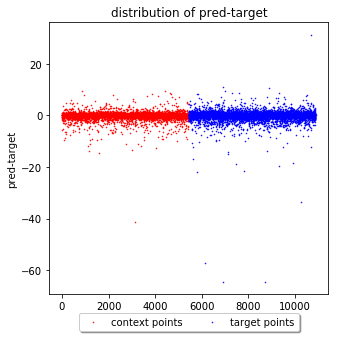

Iteration: 0, loss: -1.1846683025360107
INFO:tensorflow:global_step/sec: 1.73035
INFO:tensorflow:global_step/sec: 1.92329


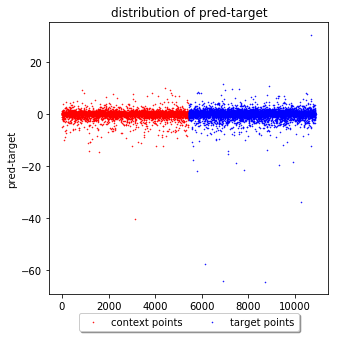

Iteration: 200, loss: -1.210098147392273
INFO:tensorflow:global_step/sec: 1.85114
INFO:tensorflow:global_step/sec: 1.85307


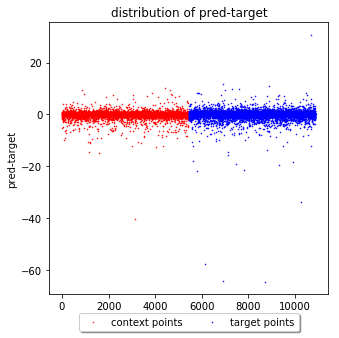

Iteration: 400, loss: -1.2056034803390503
INFO:tensorflow:global_step/sec: 1.80692
INFO:tensorflow:global_step/sec: 1.87155


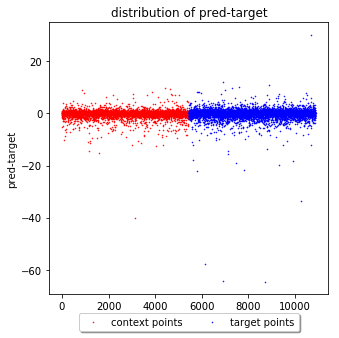

Iteration: 600, loss: -1.2121789455413818
INFO:tensorflow:global_step/sec: 1.84651
INFO:tensorflow:global_step/sec: 1.95343


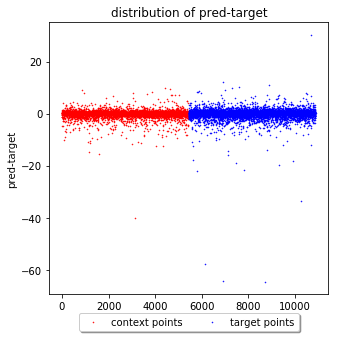

Iteration: 800, loss: -1.2169873714447021
INFO:tensorflow:global_step/sec: 1.88877
INFO:tensorflow:global_step/sec: 1.88275


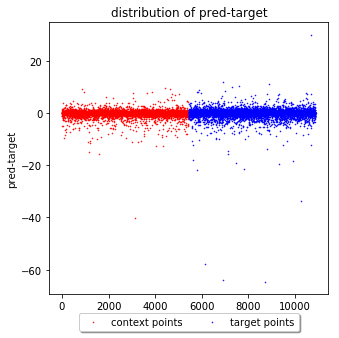

Iteration: 1000, loss: -1.2183268070220947
INFO:tensorflow:Saving checkpoints for 11099 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.59923
INFO:tensorflow:global_step/sec: 1.67992


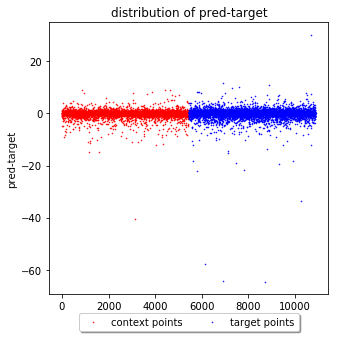

Iteration: 1200, loss: -1.2251006364822388
INFO:tensorflow:global_step/sec: 1.82662
INFO:tensorflow:global_step/sec: 1.91213


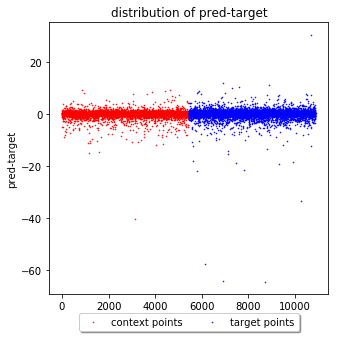

Iteration: 1400, loss: -1.2397443056106567
INFO:tensorflow:global_step/sec: 1.90122
INFO:tensorflow:global_step/sec: 1.92913


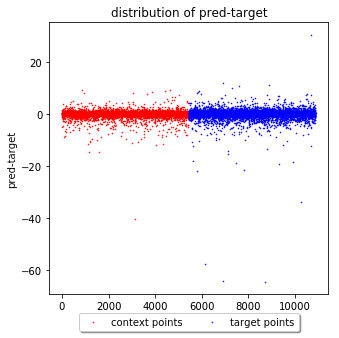

Iteration: 1600, loss: -1.2413489818572998
INFO:tensorflow:global_step/sec: 1.76562
INFO:tensorflow:global_step/sec: 1.8507


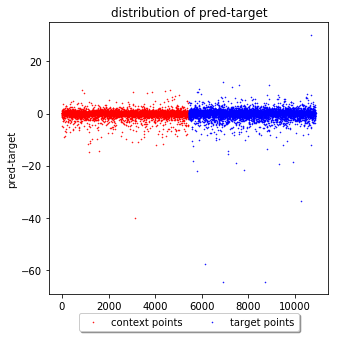

Iteration: 1800, loss: -1.2394359111785889
INFO:tensorflow:global_step/sec: 1.76538
INFO:tensorflow:global_step/sec: 1.80571


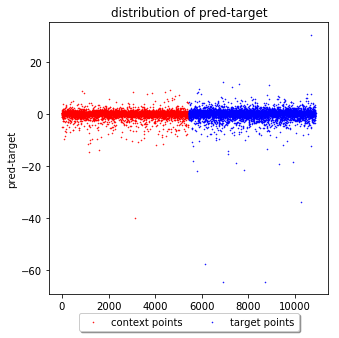

Iteration: 2000, loss: -1.2448792457580566
INFO:tensorflow:global_step/sec: 1.76406
INFO:tensorflow:Saving checkpoints for 12172 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.57021


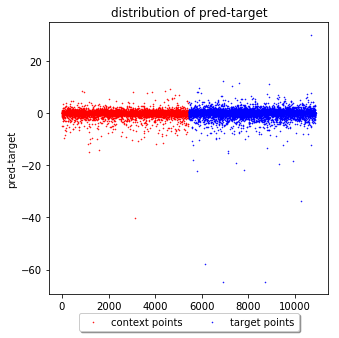

Iteration: 2200, loss: -1.2439583539962769
INFO:tensorflow:global_step/sec: 1.83206
INFO:tensorflow:global_step/sec: 1.84515


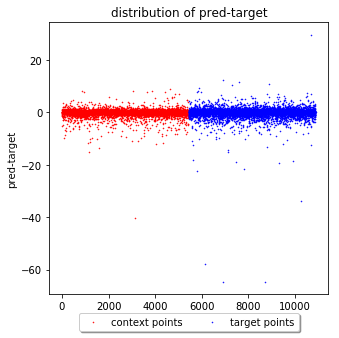

Iteration: 2400, loss: -1.2448453903198242
INFO:tensorflow:global_step/sec: 1.68683
INFO:tensorflow:global_step/sec: 1.84692


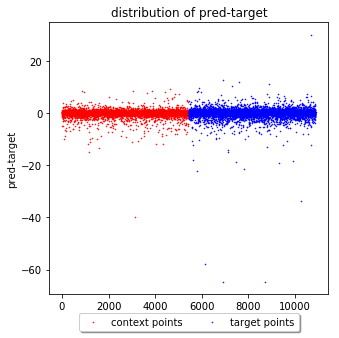

Iteration: 2600, loss: -1.2412161827087402
INFO:tensorflow:global_step/sec: 1.82038
INFO:tensorflow:global_step/sec: 1.85415


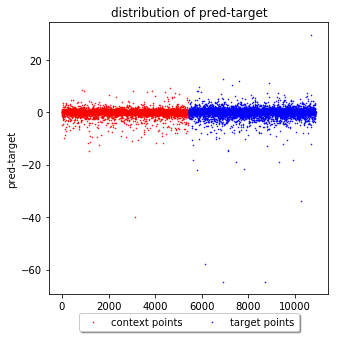

Iteration: 2800, loss: -1.2560752630233765
INFO:tensorflow:global_step/sec: 1.86616
INFO:tensorflow:global_step/sec: 1.81729


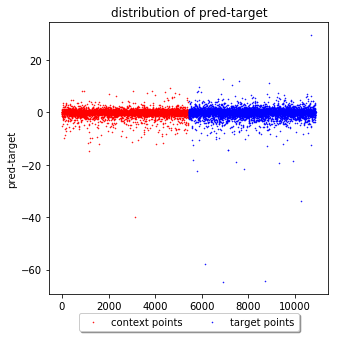

Iteration: 3000, loss: -1.2572100162506104
INFO:tensorflow:global_step/sec: 1.71449
INFO:tensorflow:global_step/sec: 1.80605


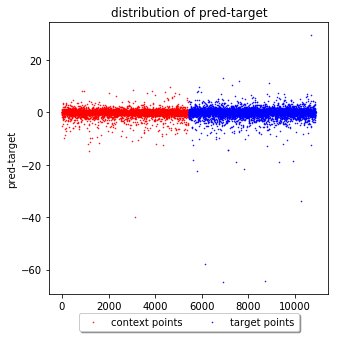

Iteration: 3200, loss: -1.2514103651046753
INFO:tensorflow:Saving checkpoints for 13245 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.56346
INFO:tensorflow:global_step/sec: 1.7979


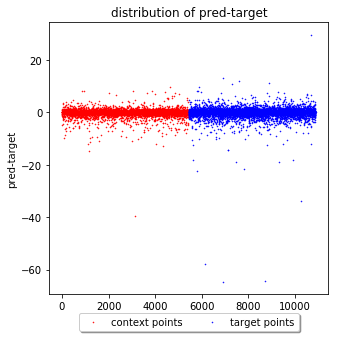

Iteration: 3400, loss: -1.2545124292373657
INFO:tensorflow:global_step/sec: 1.76948
INFO:tensorflow:global_step/sec: 1.8125


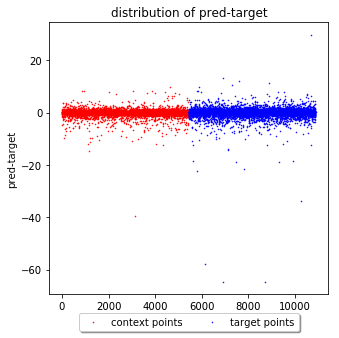

Iteration: 3600, loss: -1.2517930269241333
INFO:tensorflow:global_step/sec: 1.77244
INFO:tensorflow:global_step/sec: 1.78063


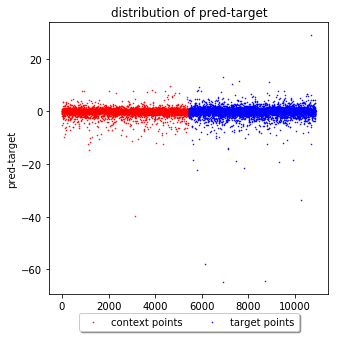

Iteration: 3800, loss: -1.25486159324646
INFO:tensorflow:global_step/sec: 1.79955
INFO:tensorflow:global_step/sec: 1.83693


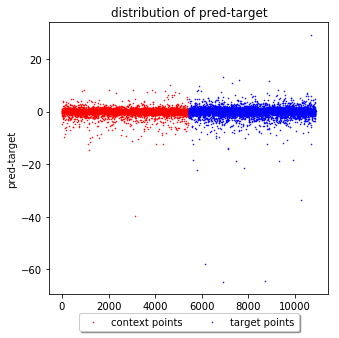

Iteration: 4000, loss: -1.266344666481018
INFO:tensorflow:global_step/sec: 1.74882
INFO:tensorflow:global_step/sec: 1.83369


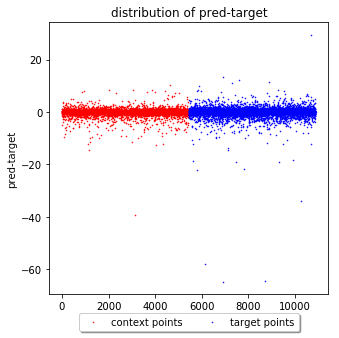

Iteration: 4200, loss: -1.2433685064315796
INFO:tensorflow:global_step/sec: 1.69558
INFO:tensorflow:Saving checkpoints for 14301 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.50235


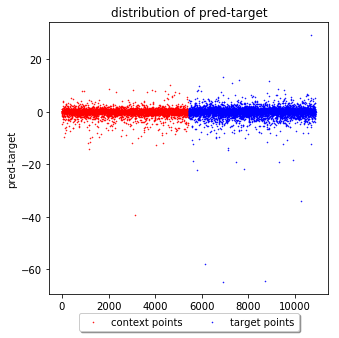

Iteration: 4400, loss: -1.2610079050064087
INFO:tensorflow:global_step/sec: 1.72753
INFO:tensorflow:global_step/sec: 1.82259


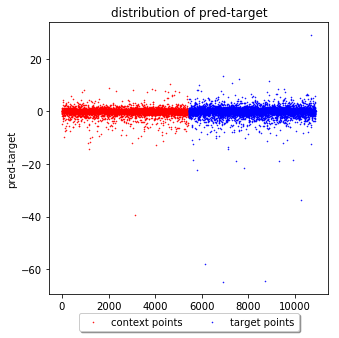

Iteration: 4600, loss: -1.2686048746109009
INFO:tensorflow:global_step/sec: 1.76103
INFO:tensorflow:global_step/sec: 1.85044


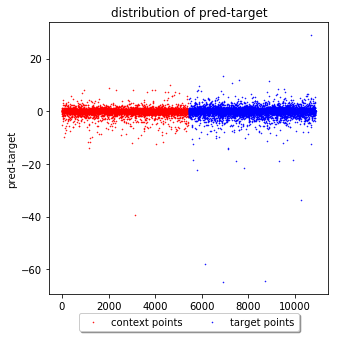

Iteration: 4800, loss: -1.2654228210449219
INFO:tensorflow:global_step/sec: 1.67182
INFO:tensorflow:global_step/sec: 1.92625


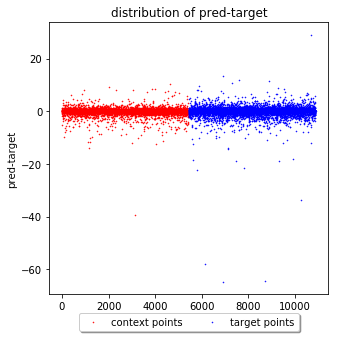

Iteration: 5000, loss: -1.2615392208099365
INFO:tensorflow:global_step/sec: 1.75816
INFO:tensorflow:global_step/sec: 1.87727


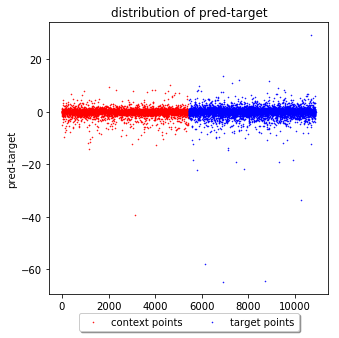

Iteration: 5200, loss: -1.2697961330413818
INFO:tensorflow:global_step/sec: 1.76415
INFO:tensorflow:Saving checkpoints for 15359 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.59821


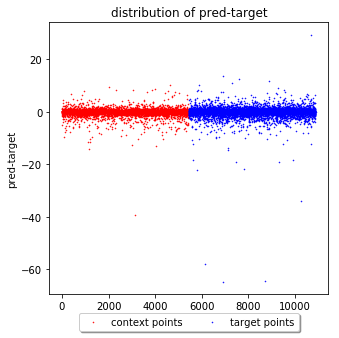

Iteration: 5400, loss: -1.268576979637146
INFO:tensorflow:global_step/sec: 1.82099
INFO:tensorflow:global_step/sec: 1.86966


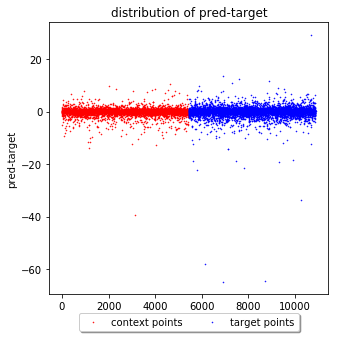

Iteration: 5600, loss: -1.2708122730255127
INFO:tensorflow:global_step/sec: 1.73405
INFO:tensorflow:global_step/sec: 1.81865


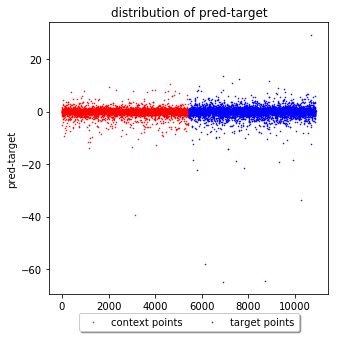

Iteration: 5800, loss: -1.2761566638946533
INFO:tensorflow:global_step/sec: 1.68834
INFO:tensorflow:global_step/sec: 1.87329


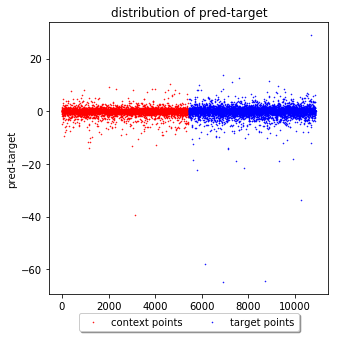

Iteration: 6000, loss: -1.2787916660308838
INFO:tensorflow:global_step/sec: 1.75827
INFO:tensorflow:global_step/sec: 1.73031


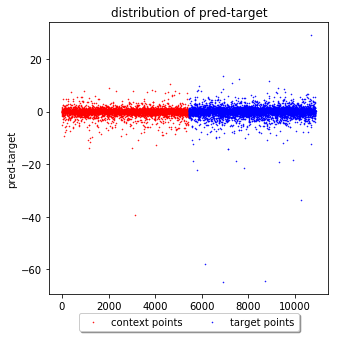

Iteration: 6200, loss: -1.2725342512130737
INFO:tensorflow:global_step/sec: 1.7611
INFO:tensorflow:global_step/sec: 1.80903


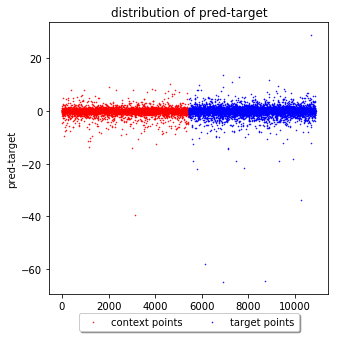

Iteration: 6400, loss: -1.2808876037597656
INFO:tensorflow:Saving checkpoints for 16416 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.4938
INFO:tensorflow:global_step/sec: 1.86974


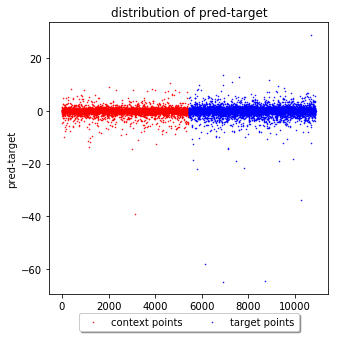

Iteration: 6600, loss: -1.2820565700531006
INFO:tensorflow:global_step/sec: 1.85455
INFO:tensorflow:global_step/sec: 1.75719


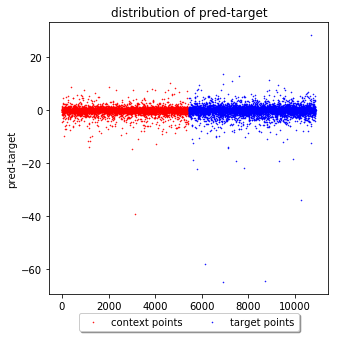

Iteration: 6800, loss: -1.2735036611557007
INFO:tensorflow:global_step/sec: 1.72931
INFO:tensorflow:global_step/sec: 1.80894


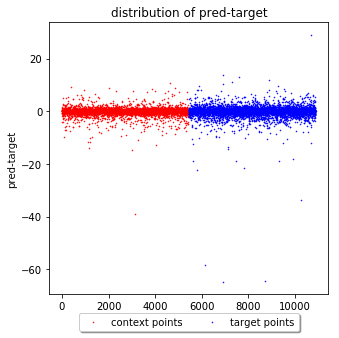

Iteration: 7000, loss: -1.2794148921966553
INFO:tensorflow:global_step/sec: 1.75591
INFO:tensorflow:global_step/sec: 1.88098


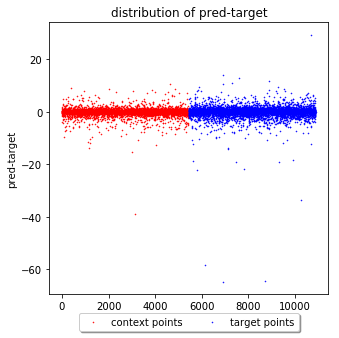

Iteration: 7200, loss: -1.2752885818481445
INFO:tensorflow:global_step/sec: 1.74302
INFO:tensorflow:global_step/sec: 1.89889


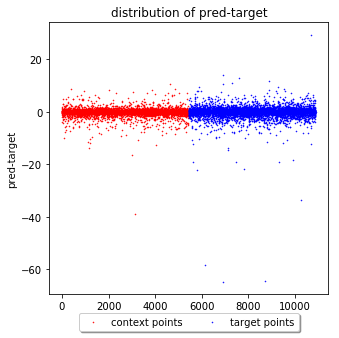

Iteration: 7400, loss: -1.2847691774368286
INFO:tensorflow:Saving checkpoints for 17486 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.55574
INFO:tensorflow:global_step/sec: 1.9437


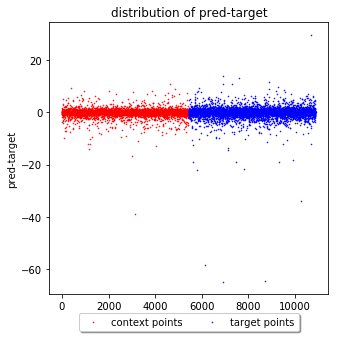

Iteration: 7600, loss: -1.2854443788528442
INFO:tensorflow:global_step/sec: 1.8674
INFO:tensorflow:global_step/sec: 1.92381


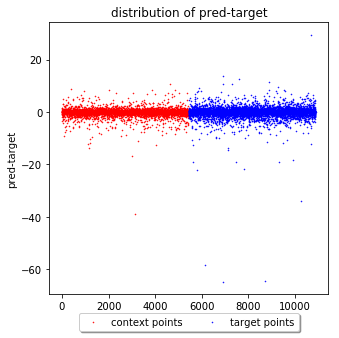

Iteration: 7800, loss: -1.279180645942688
INFO:tensorflow:global_step/sec: 1.88023
INFO:tensorflow:global_step/sec: 1.90807


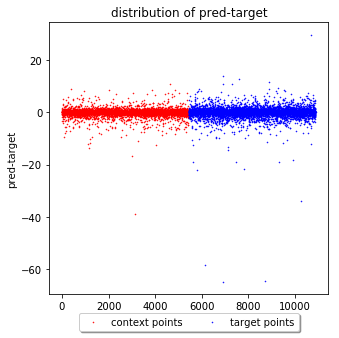

Iteration: 8000, loss: -1.2820442914962769
INFO:tensorflow:global_step/sec: 1.84935
INFO:tensorflow:global_step/sec: 1.81725


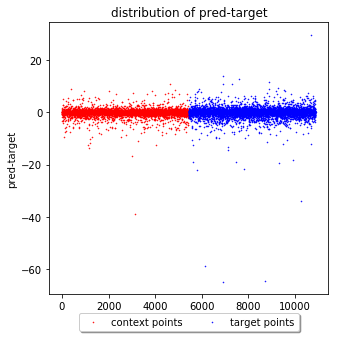

Iteration: 8200, loss: -1.287343978881836
INFO:tensorflow:global_step/sec: 1.76855
INFO:tensorflow:global_step/sec: 1.83993


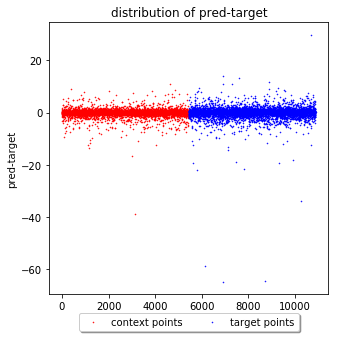

Iteration: 8400, loss: -1.2889467477798462
INFO:tensorflow:global_step/sec: 1.7977
INFO:tensorflow:Saving checkpoints for 18583 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.63838


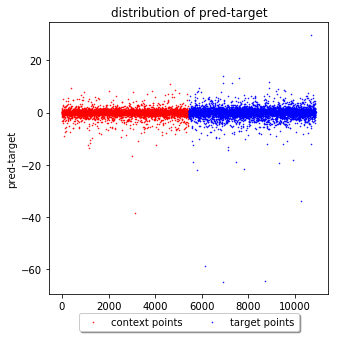

Iteration: 8600, loss: -1.289320468902588
INFO:tensorflow:global_step/sec: 1.8778
INFO:tensorflow:global_step/sec: 1.93003


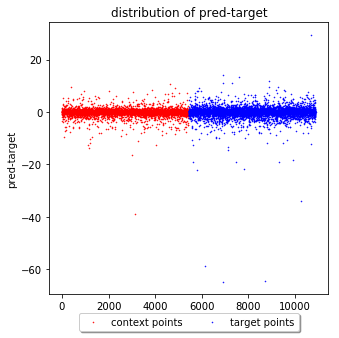

Iteration: 8800, loss: -1.2809464931488037
INFO:tensorflow:global_step/sec: 1.75065
INFO:tensorflow:global_step/sec: 1.85793


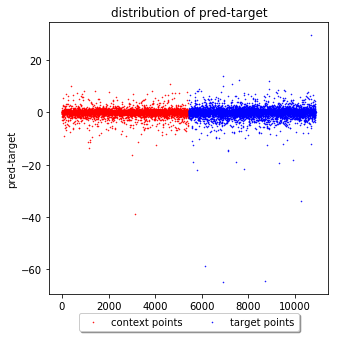

Iteration: 9000, loss: -1.2869800329208374
INFO:tensorflow:global_step/sec: 1.82815
INFO:tensorflow:global_step/sec: 1.82596


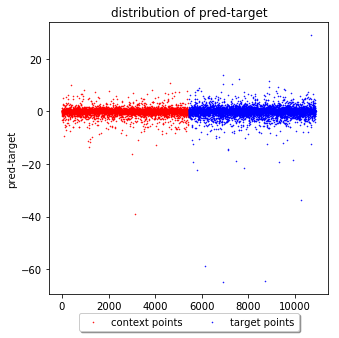

Iteration: 9200, loss: -1.2868446111679077
INFO:tensorflow:global_step/sec: 1.76747
INFO:tensorflow:global_step/sec: 1.83978


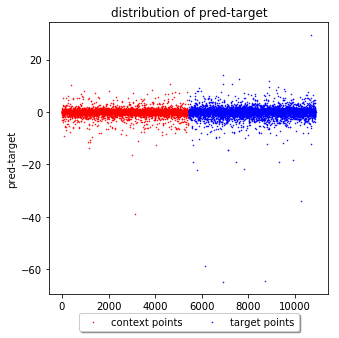

Iteration: 9400, loss: -1.2882792949676514
INFO:tensorflow:global_step/sec: 1.71139
INFO:tensorflow:global_step/sec: 1.78707


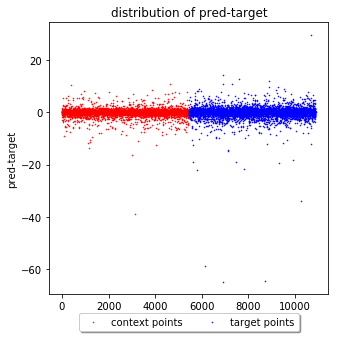

Iteration: 9600, loss: -1.2885836362838745
INFO:tensorflow:Saving checkpoints for 19659 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.58151
INFO:tensorflow:global_step/sec: 1.66446


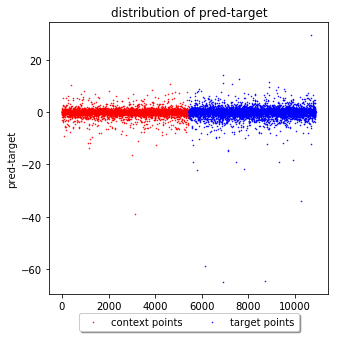

Iteration: 9800, loss: -1.2828317880630493
INFO:tensorflow:global_step/sec: 1.75228
INFO:tensorflow:Saving checkpoints for 20000 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt.


In [0]:
TRAINING_ITERATIONS = 10000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 200 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()

# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)
print("start wrapping data...")
# Define data
batch_size = 50
print("start wrapping training data...")
train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)
print("finish...")
print("start wrapping testing data")
test_query, test_target_y, test_num_total_points, test_num_context_points = testdatawrap(test_norm_x, test_norm_y, test_norm_x.shape[0])
print("finish wrapping data...")
# Define the loss
_, _, log_prob, LL, _, loss = model(train_query, train_num_total_points,
                                 train_target_y)

# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _, _ = model(test_query, test_num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
global_step = tf.train.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)
init = tf.initialize_all_variables()

LL_set = []
LL_set_x = []
saver = tf.train.Saver(max_to_keep=1)
print("start doing prediction...")
# Train and plot
with tf.train.MonitoredTrainingSession(checkpoint_dir="/home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt", save_checkpoint_secs=600) as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state("/home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt")
    
  if ckpt and ckpt.model_checkpoint_path:
            # Restores from checkpoint
    saver.restore(sess, ckpt.model_checkpoint_path)
  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])
    
    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, std_y, target_y, whole_query, LL_value = sess.run(
          [loss, mu, sigma, test_target_y, 
           test_query, LL])
      #print("The accuracy is .....")
      accuracy = abs((pred_y-target_y)/target_y)
      accuracy = np.reshape(accuracy, accuracy.shape[1])
      #print(np.mean(accuracy))
    
      # record LL in each itr
      LL_set.append(LL_value)
      #LL_set_X.append(itr)
  
      plt.figure(figsize=(5,5)) 
      con_y = pred_y[:,:int(0.5 * test_num_total_points)] - target_y[:,:int(0.5 * test_num_total_points)]
      tar_y = pred_y[:,int(0.5 * test_num_total_points):] - target_y[:,int(0.5 * test_num_total_points):]
      X1 = np.arange(int(0.5 * test_num_total_points))
      X2 = np.arange(int(0.5 * test_num_total_points),test_num_total_points)
      s_con = plt.scatter(X1,con_y,color='red',s=0.3,label='context points')
      s_tar = plt.scatter(X2,tar_y,color='blue',s=0.3,label='target points')
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
      plt.xlabel('')
      plt.ylabel('pred-target')
      plt.title(r'distribution of pred-target')
      plt.show()
     
      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))


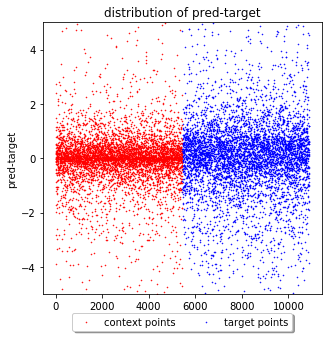

In [0]:
plt.figure(figsize=(5,5)) 
con_y = pred_y[:,:int(0.5 * test_num_total_points)] - target_y[:,:int(0.5 * test_num_total_points)]
tar_y = pred_y[:,int(0.5 * test_num_total_points):] - target_y[:,int(0.5 * test_num_total_points):]
X1 = np.arange(int(0.5 * test_num_total_points))
X2 = np.arange(int(0.5 * test_num_total_points),test_num_total_points)
s_con = plt.scatter(X1,con_y,color='red',s=0.3,label='context points')
s_tar = plt.scatter(X2,tar_y,color='blue',s=0.3,label='target points')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.xlabel('')
plt.ylim(-5,5)
plt.ylabel('pred-target')
plt.title(r'distribution of pred-target')
plt.show()

###  main (panstarrs and gaia) 

start wrapping data...
start wrapping training data...
finish...
start wrapping testing data...
finish wrapping data...
doing prediction...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/model.ckpt/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8000 into ./model/model.ckpt/model.ckpt.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt/model.ckpt-8000
INFO:tensorflow:global_step/sec: 1050.45


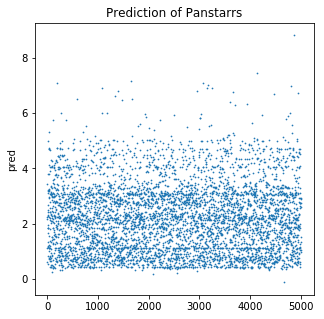

Iteration: 0, prediction: [[[0.8562646]
  [3.1604643]
  [0.9036481]
  ...
  [2.6031861]
  [2.916932 ]
  [2.7404046]]]
INFO:tensorflow:global_step/sec: 1.75425
INFO:tensorflow:global_step/sec: 1.77953


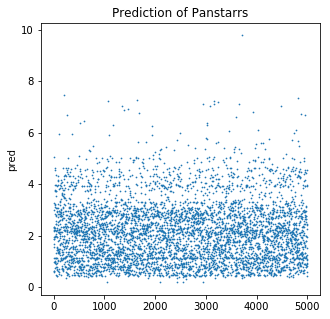

Iteration: 200, prediction: [[[0.95212793]
  [3.03328   ]
  [1.027755  ]
  ...
  [2.2642007 ]
  [1.9487336 ]
  [2.4021964 ]]]
INFO:tensorflow:global_step/sec: 1.74737
INFO:tensorflow:global_step/sec: 1.7918


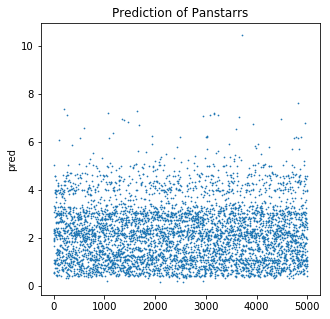

Iteration: 400, prediction: [[[0.9048859]
  [3.1471896]
  [0.9788768]
  ...
  [2.3876915]
  [1.968583 ]
  [2.4558477]]]
INFO:tensorflow:global_step/sec: 1.75663
INFO:tensorflow:global_step/sec: 1.80456


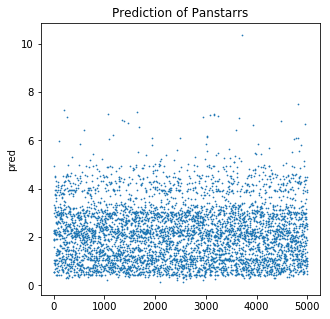

Iteration: 600, prediction: [[[0.8798197 ]
  [3.165245  ]
  [0.91101736]
  ...
  [2.3388255 ]
  [1.8989938 ]
  [2.456783  ]]]
INFO:tensorflow:global_step/sec: 1.57486
INFO:tensorflow:global_step/sec: 1.80324


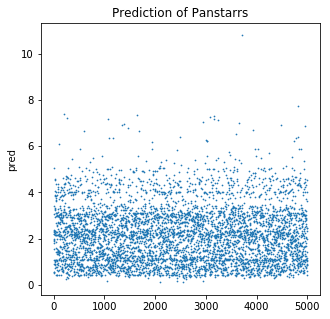

Iteration: 800, prediction: [[[0.8948306]
  [3.1329715]
  [0.9299266]
  ...
  [2.3330872]
  [1.9735758]
  [2.4765234]]]
INFO:tensorflow:global_step/sec: 1.77736
INFO:tensorflow:Saving checkpoints for 9000 into ./model/model.ckpt/model.ckpt.


In [0]:
TRAINING_ITERATIONS = 1000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 200 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()

# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

# Define data
batch_size = 50
print("start wrapping data...")
print("start wrapping training data...")
train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)
print("finish...")
print("start wrapping testing data...")
test_query, test_target_y, test_num_total_points, test_num_context_points = pan_testdatawrap(test_norm_x, test_norm_y, pan_target_x, test_norm_x.shape[0])

# Define the loss
_, _, log_prob, LL, _, loss = model(train_query, train_num_total_points,
                                 train_target_y)
print("finish wrapping data...")
# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _, _ = model(test_query, test_num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
global_step = tf.train.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)
init = tf.initialize_all_variables()

#initialize best loss and LL
best_loss = 100000

LL_set = []
LL_set_x = []
saver = tf.train.Saver(max_to_keep=1)
# Train and plot
print("doing prediction...")
with tf.train.MonitoredTrainingSession(checkpoint_dir="./model/model.ckpt", save_checkpoint_secs=600) as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state("./model/model.ckpt")
  if ckpt and ckpt.model_checkpoint_path:
            # Restores from checkpoint
    saver.restore(sess, ckpt.model_checkpoint_path)
  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])
    
    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      pred_y, std_y, whole_query = sess.run([ mu, sigma, test_query])
      
      plt.figure(figsize=(5,5)) 
      plt.scatter(np.arange(pan_target_x.shape[0]), pred_y[:,test_norm_x.shape[0]:,:], s=0.5)
      plt.xlabel('')
      plt.ylabel('pred')
      plt.title(r'Prediction of Panstarrs')
      plt.show()
    
      print('Iteration: {}, prediction: {}'.format(it, pred_y))

## **Evaluation**

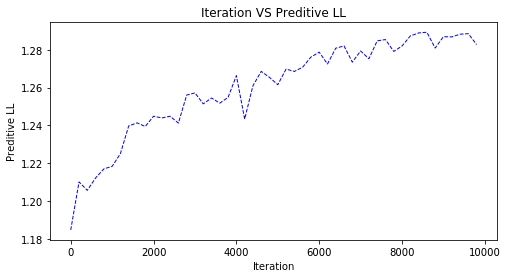

In [0]:
# LL vs itr
x = np.arange(0,10000,200)
y = LL_set
plt.figure(figsize=(8,4))
plt.plot(x, y, "b--",linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Preditive LL')
plt.title(r'Iteration VS Preditive LL')
plt.show()


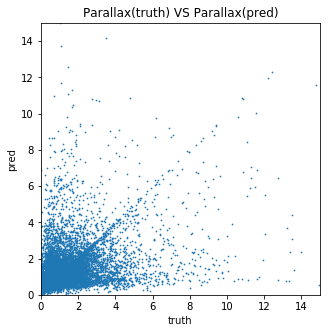

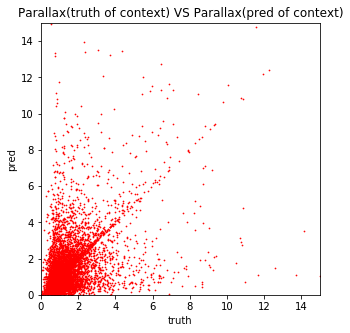

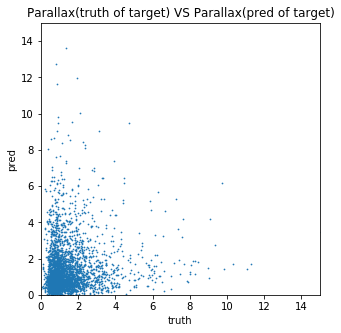

In [0]:
# ground truth vs pred (all)
plt.figure(figsize=(5,5)) 
plt.scatter(target_y, pred_y, s=0.5)
plt.xlabel('truth')
plt.ylabel('pred')
plt.xlim(0,15)
plt.ylim(0,15)
plt.title(r'Parallax(truth) VS Parallax(pred)')
plt.show()

con_pred_y = pred_y[:,:int(0.7 * test_num_total_points)]
con_target_y = target_y[:,:int(0.7 * test_num_total_points)]

tar_pred_y = pred_y[:,int(0.7 * test_num_total_points):]
tar_target_y = target_y[:,int(0.7 * test_num_total_points):]
# ground truth(context) vs pred(target)
plt.figure(figsize=(5,5)) 
plt.scatter(con_pred_y, con_target_y, s=0.5,color='red')
plt.xlabel('truth')
plt.ylabel('pred')
plt.xlim(0,15)
plt.ylim(0,15)
plt.title(r'Parallax(truth of context) VS Parallax(pred of context)')
plt.show()

# ground truth(context) vs pred(target)
plt.figure(figsize=(5,5)) 
plt.scatter(tar_pred_y, tar_target_y, s=0.5)
plt.xlabel('truth')
plt.ylabel('pred')
plt.xlim(0,15)
plt.ylim(0,15)
plt.title(r'Parallax(truth of target) VS Parallax(pred of target)')
plt.show()


In [0]:
acc = abs(pred_y - target_y)/target_y
print(np.mean(abs(pred_y - target_y)/target_y))

2.4259129


(1, 10891, 1)


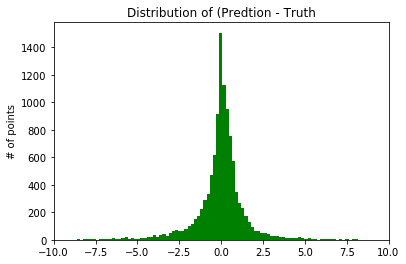

(1, 7623, 1)


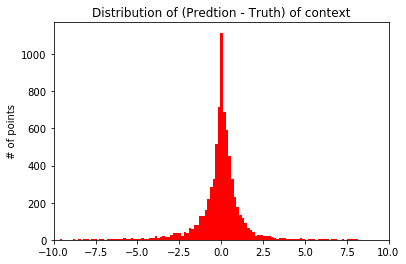

(1, 3268, 1)


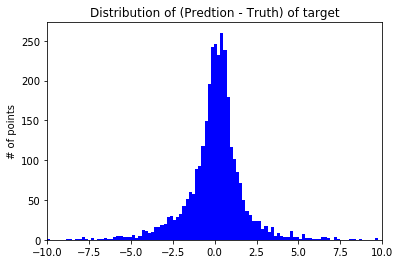

In [0]:
num_bins = 500
acc = pred_y - target_y
print(acc.shape)
n, bins, patches = plt.hist(acc[0], num_bins, facecolor='green', alpha=1)
plt.title(r'Distribution of (Predtion - Truth')
plt.ylabel('# of points')
plt.xlim(-10, 10)
plt.show()

# case of context
num_bins = 500
acc = con_pred_y - con_target_y
print(acc.shape)
n, bins, patches = plt.hist(acc[0], num_bins, facecolor='red', alpha=1)
plt.title(r'Distribution of (Predtion - Truth) of context' )
plt.ylabel('# of points')
plt.xlim(-10, 10)
plt.show()

# case of target
num_bins = 500
acc = tar_pred_y - tar_target_y
print(acc.shape)
n, bins, patches = plt.hist(acc[0], num_bins, facecolor='blue', alpha=1)
plt.title(r'Distribution of (Predtion - Truth) of target' )
plt.ylabel('# of points')
plt.xlim(-10, 10)
plt.show()

## Unwise data processing

In [0]:
# read files, would take few hours, dont run!!
from astropy.table import Table
import glob, os
print("crossing matching...34000 totoal")
unwise_df = pd.DataFrame()
os.chdir("/home/yufeng/projects/rrg-kyi/data/astro/stars/unwise/release/cat/")
count = 0
for file in glob.glob("*.fits"):
    count += 1 
    df = Table.read(file).to_pandas()
    df = df.loc[(df['ra']>=-60) & (df['ra']<=50) & (df['dec']<=0.5) & (df['dec']>=-0.5)]
    unwise_df = unwise_df.append(df)
    if count%1000==0 :
        print(count)
print("done")

In [0]:
# read csv
filename = '/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/selected_wise.csv'
unwise_new_df = pd.read_csv(filename)
# add wavelength
unwise_new_df['wavelength'] = np.where(unwise_new_df['band']==1, 33526, 46028)
unwise_new_df.head()

,Unnamed: 0,x,y,flux,dx,dy,dflux,qf,rchi2,fracflux,...,ra,dec,coadd_id,band,unwise_detid,nm,primary,flags_unwise,flags_info,wavelength
0,7940,368.939900,934.901125,155.086850,0.084313,0.083965,7.537626,1.0,0.327513,0.946809,...,49.983835,-0.499998,b'0499p000',1,b'0499p000w1o0007940',121,1,0,0,33526
1,7943,369.487629,1085.276662,63.110485,0.200511,0.199685,7.236599,1.0,0.693012,0.911250,...,49.868965,-0.499580,b'0499p000',1,b'0499p000w1o0007943',125,1,0,0,33526
2,7944,369.491954,1099.625032,62.952230,0.199331,0.199811,7.128104,1.0,0.554260,0.893760,...,49.858004,-0.499577,b'0499p000',1,b'0499p000w1o0007944',130,1,0,0,33526
3,7945,369.073169,1118.810144,118.698740,0.106537,0.106234,7.256862,1.0,1.037835,0.777629,...,49.843349,-0.499896,b'0499p000',1,b'0499p000w1o0007945',133,1,0,0,33526
4,7946,369.276967,1206.702860,82.446625,0.152840,0.152952,7.176266,1.0,0.678155,0.787403,...,49.776209,-0.499740,b'0499p000',1,b'0499p000w1o0007946',129,1,0,0,33526


In [0]:
import math
# select the attributes
selectedf = ['ra', 'dec', 'flux', 'wavelength']
unwise_selected_df = unwise_new_df.loc[:, selectedf]

#drop row with flux < 0
indexNames = unwise_selected_df[unwise_selected_df['flux'] < 0].index
unwise_selected_df.drop(indexNames, inplace=True)

# convert flux into mag
# formula is mag = 22.5 - 2.5log(flux)
unwise_selected_df['flux'] = unwise_selected_df['flux'].apply(lambda x: 22.5 - (2.5*math.log10(x)))

#rename 'flux' as 'mag'
unwise_selected_df = unwise_selected_df.rename(columns={'flux':"mag"})
unwise_selected_df.head()

,ra,dec,mag,wavelength
0,49.983835,-0.499998,17.023563,33526
1,49.868965,-0.499580,17.999746,33526
2,49.858004,-0.499577,18.002472,33526
3,49.843349,-0.499896,17.313885,33526
4,49.776209,-0.499740,17.709568,33526


In [0]:
locations = np.random.choice(unwise_selected_df.shape[0],
                                 size=5000,
                                 replace=False)

unwise_target_x = Normalization(unwise_selected_df)
unwise_target_x = np.array(unwise_target_x)[locations,:]
pd.DataFrame(unwise_target_x).head()

,0,1,2,3
0,0.482233,0.614471,0.663751,0.988894
1,0.816329,0.597157,0.598845,0.694729
2,0.475729,0.398083,0.629335,0.988894
3,0.883319,0.617410,0.666265,0.694729
4,0.630754,0.692112,0.627393,0.988894


### Main (Unwise and Gaia)

start wrapping data...
start wrapping training data...
finish...
start wrapping testing data...
finish wrapping data...
doing prediction...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9000 into ./model/model.ckpt/model.ckpt.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt/model.ckpt-9000
INFO:tensorflow:global_step/sec: 1189.45


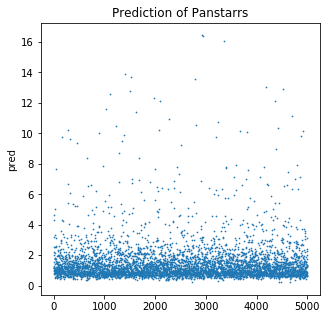

Iteration: 0, prediction: [[[0.7057487 ]
  [1.304362  ]
  [1.2412374 ]
  ...
  [1.287974  ]
  [0.83102643]
  [1.2012416 ]]]
INFO:tensorflow:global_step/sec: 1.67202
INFO:tensorflow:global_step/sec: 1.64257


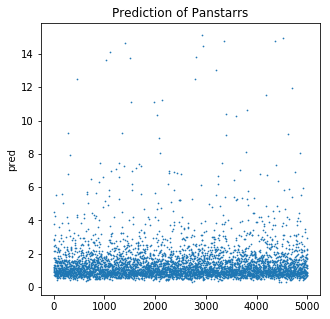

Iteration: 200, prediction: [[[0.6556786 ]
  [0.82460713]
  [1.0306877 ]
  ...
  [1.2720499 ]
  [0.82621217]
  [1.1271261 ]]]
INFO:tensorflow:global_step/sec: 1.75346
INFO:tensorflow:global_step/sec: 1.79444


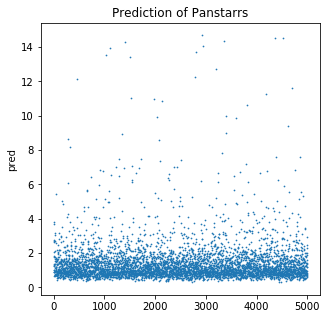

Iteration: 400, prediction: [[[0.66037387]
  [0.8253858 ]
  [1.0784583 ]
  ...
  [1.4000697 ]
  [0.8001601 ]
  [1.1781425 ]]]
INFO:tensorflow:global_step/sec: 1.76394
INFO:tensorflow:global_step/sec: 1.82296


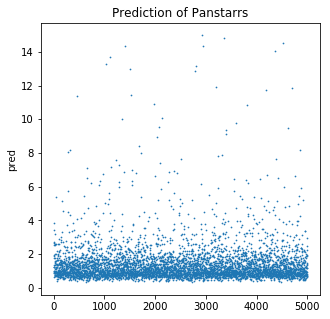

Iteration: 600, prediction: [[[0.67527956]
  [0.83918536]
  [1.0467778 ]
  ...
  [1.3757324 ]
  [0.7798922 ]
  [1.1855836 ]]]
INFO:tensorflow:global_step/sec: 1.7846
INFO:tensorflow:global_step/sec: 1.81302


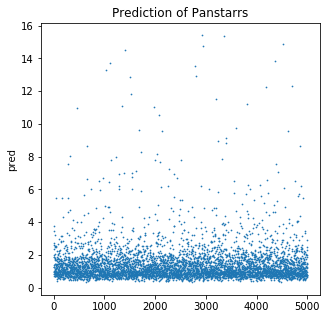

Iteration: 800, prediction: [[[0.67077714]
  [0.8577742 ]
  [1.0431348 ]
  ...
  [1.4327626 ]
  [0.7708601 ]
  [1.2285135 ]]]
INFO:tensorflow:global_step/sec: 1.65386
INFO:tensorflow:Saving checkpoints for 10000 into ./model/model.ckpt/model.ckpt.


In [0]:
TRAINING_ITERATIONS = 1000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 200 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()

# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

# Define data
batch_size = 50
print("start wrapping data...")
print("start wrapping training data...")
train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)
print("finish...")
print("start wrapping testing data...")
test_query, test_target_y, test_num_total_points, test_num_context_points = pan_testdatawrap(test_norm_x, test_norm_y, unwise_target_x, test_norm_x.shape[0])

# Define the loss
_, _, log_prob, LL, _, loss = model(train_query, train_num_total_points,
                                 train_target_y)
print("finish wrapping data...")
# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _, _ = model(test_query, test_num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
global_step = tf.train.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)
init = tf.initialize_all_variables()

#initialize best loss and LL
best_loss = 100000

LL_set = []
LL_set_x = []
saver = tf.train.Saver(max_to_keep=1)
# Train and plot
print("doing prediction...")
with tf.train.MonitoredTrainingSession(checkpoint_dir="./model/model.ckpt", save_checkpoint_secs=600) as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state("./model/model.ckpt")
  if ckpt and ckpt.model_checkpoint_path:
            # Restores from checkpoint
    saver.restore(sess, ckpt.model_checkpoint_path)
  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])
    
    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      pred_y, std_y, whole_query = sess.run([ mu, sigma, test_query])
      
      plt.figure(figsize=(5,5)) 
      plt.scatter(np.arange(pan_target_x.shape[0]), pred_y[:,test_norm_x.shape[0]:,:], s=0.5)
      plt.xlabel('')
      plt.ylabel('pred')
      plt.title(r'Prediction of Panstarrs')
      plt.show()
    
      print('Iteration: {}, prediction: {}'.format(it, pred_y))